In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/radioml2016-deepsigcom/RML2016.10a_dict.pkl


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Conv2D, MaxPool2D, ZeroPadding2D, Dense, Dropout, Activation, Flatten, GaussianNoise

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pickle

In [7]:
def digitizer(labels):
    
    unique_labels = np.unique(labels)
    label_dict = {}
    num = 1
    for i in unique_labels:
        label_dict[i] = num
        num += 1 
    
    digit_label = []
    for i in labels:
        digit_label.append(label_dict[i])
    
    return label_dict,  digit_label 
    
            
def onehot_encoder(L_dict,  labels):
    num_classes = len(L_dict)
    vector = np.zeros(num_classes)
    vector[L_dict[labels]-1] = 1
    return vector



def confusion_matrix_create (y_true, y_pred, labels_dict, title):
    
    labels = []
    for i in labels_dict.items():
        labels.append(i[0])
    y_true = np.argmax(y_true, axis =1)
    y_true = np.array(y_true) + 1
    y_pred = np.array(y_pred) + 1
    
    
    
    updated_pred = []
    updated_true = []

    for i in range(len(y_true)):

        for key,value in labels_dict.items():
            if value == y_true[i]:
                updated_true.append(key)

            if value == y_pred[i]:
                updated_pred.append(key)

    cm = confusion_matrix(updated_true,updated_pred, labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.xticks(ticks=[-1,0,1,2,3,4,5,6,7,8,9,10], rotation=45)
    plt.yticks(ticks=[-1,0,1,2,3,4,5,6,7,8,9,10], rotation=45)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    ax.set (title=title, 
            ylabel='True label',
            xlabel='Predicted label')
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.show()

In [8]:
import numpy as np
import pickle 

with open('/kaggle/input/radioml2016-deepsigcom/RML2016.10a_dict.pkl', "rb") as p:
    d = pickle.load(p, encoding='latin1')

classes = []    
for i in d.keys():    
    if i[0] not in classes:
        classes.append(i[0])

# creating class dictionary for strings to digits transformation.
label_dict,  digit_label = digitizer(classes)



SNRs = {}
for key in d.keys():
    if key not in SNRs:
        SNRs[key[1]] = []
SNRs.keys()



j = 0
for keys in d.keys():
    for arrays in d[keys]:
        # convert labels to one-hot encoders.
        SNRs[keys[1]].append([onehot_encoder(label_dict, keys[0]),np.array(arrays)]) 

outfile = open('dataset','wb')
pickle.dump(SNRs,outfile)
outfile.close()


outfile = open('class_dict','wb')
pickle.dump(label_dict,outfile)
outfile.close()

In [9]:
import pickle
import itertools
from random import shuffle

with open('dataset', 'rb') as file:
    data = pickle.load(file, encoding='Latin')

for key in data.keys():
    shuffle(data[key])

new_data = {'combined': []}
SNR_test = {}

for key in data.keys():
    train_len = int(0.9 * len(data[key]))
    new_data['combined'].append(data[key][:train_len])
    SNR_test[key] = data[key][train_len:]

new_data['combined'] = list(itertools.chain.from_iterable(new_data['combined']))

outfile = open('new_model_SNR_test_samples', 'wb')
pickle.dump(SNR_test, outfile)
outfile.close()

outfile = open('combined_SNR_data', 'wb')
pickle.dump(new_data, outfile)
outfile.close()

In [1]:
from keras.datasets import cifar10
from keras.utils import np_utils
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, LSTM, BatchNormalization
from keras import metrics
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD
import pickle
import matplotlib.pyplot as plt
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.callbacks import EarlyStopping

def CLDNN():
    model = Sequential()
    model.add(Conv2D(120, 10, activation='relu', padding='same',kernel_initializer= 'glorot_uniform',input_shape=(2, 128, 1)))
    model.add(MaxPooling2D(pool_size=(1, 2), padding='valid',  data_format=None))
    model.add(layers.Dropout(0.3))

    model.add(Conv2D(80, 10, activation='relu',kernel_initializer= 'glorot_uniform', padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2), padding='valid',  data_format=None))
    model.add(layers.Dropout(0.3))
    
    model.add(Conv2D(60, 10, activation='relu',kernel_initializer= 'glorot_uniform', padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2), padding='valid',  data_format=None))
    model.add(layers.Dropout(0.3))
    
    model.add(Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))

    model.add(Reshape((2, 2048)))

    model.add(LSTM(128,activation='relu'))
    model.add(layers.Dropout(0.3))

    model.add(Dense(128, activation='relu',kernel_initializer= 'he_normal'))
    model.add(layers.Dropout(0.3))

    model.add(Dense(11, activation='softmax',kernel_initializer= 'he_normal'))

    return model

def Robust_CNN():
    
    model = Sequential()
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same',kernel_initializer= 'glorot_uniform', input_shape=(2,128,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 2), padding='valid',  data_format=None))
    model.add(layers.Dropout(.3))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer= 'glorot_uniform',))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 2), padding='valid', data_format=None))
    model.add(layers.Dropout(.3))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer= 'glorot_uniform',))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 2), padding='valid', data_format=None))
    model.add(layers.Dropout(.3))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer= 'glorot_uniform',))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 2), padding='valid', data_format=None))
    model.add(layers.Dropout(.3))
    model.add(Flatten())
    model.add(Dense(128, activation='relu',kernel_initializer= 'he_normal'))
    model.add(BatchNormalization())
    model.add(Dense(11, activation='softmax',kernel_initializer= 'he_normal'))
    
    return model

def DNN():
    model = Sequential()
    model.add(Dense(512,activation='relu'))
    model.add(Dense(256,activation='relu'))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(11,activation='softmax'))
    return model

def Robust_LSTM():
    model = Sequential()
    model.add(LSTM(units=300,activation='relu',input_shape=(2,128)))
    model.add(BatchNormalization())
    model.add(layers.Dropout(.3))
    model.add(Reshape((2,150)))
    model.add(LSTM(units=200,activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.Dropout(.3))
    model.add(Reshape((2,25)))
    model.add(layers.Dropout(.3))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(11,activation='softmax'))
    return model

In [ ]:
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np
# Use this code only if you want to generate 20 different models corresponding to 20 SNR values
accuracies_All = []
confusion_matrices_All = []

for key in SNRs.keys():
    dataset = []
    labels = []

    for values in SNRs[key]:
        labels.append(values[0])
        dataset.append(values[1])

    print('Starting training for SNR:', key)

    N = len(dataset)
    shuffled_indeces = np.random.permutation(range(N))
    new_dataset = np.array(dataset)[shuffled_indeces,:,:]
    new_labels = np.array(labels)[shuffled_indeces,:]

    num_train = int(0.8*N)
    x_train = new_dataset[:num_train,:,:]
    y_train = new_labels[:num_train,:]

    num_val = int(0.1*len(x_train))

    x_val = x_train[:num_val,:,:]
    x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],x_val.shape[2], -1)
    y_val = y_train[:num_val,:]

    x_train = x_train[num_val:,:,:]
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2], -1)
    y_train = y_train[num_val:,:]

    x_test = new_dataset[num_train:,:,:]
    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2], -1)
    y_test = new_labels[num_train:,:]

    models = CLDNN()
    opt = Adam(learning_rate=0.0003)
    models.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    num_epochs = 300

    # Checkpoint for models
    ckpt_folder = "cldnn_models/"
    ckpt_file_path = 'cldnn_model_SNR_{}'.format(key)
    if not os.path.exists(ckpt_folder):
        os.mkdir(ckpt_folder)
    model_ckpt_callback = ModelCheckpoint(filepath=ckpt_folder+ckpt_file_path,monitor='val_loss', mode='min', save_best_only=True)
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, verbose=1, epsilon=1e-4, mode='min')

    history = models.fit(x_train,
                         y_train,
                         epochs=num_epochs,
                         batch_size=200,
                         callbacks = [reduce_lr_loss, model_ckpt_callback],
                         validation_data=(x_val, y_val))
    loss, acc = models.evaluate(x_test, y_test, verbose=2)
    predicted_data = models.predict(x_test)
    accuracies_All.append([acc, key])
    print('accuracy =', acc)
    res = np.argmax(predicted_data, 1)
    y_test_res = np.argmax(y_test, 1)
    results = confusion_matrix((y_test_res+1), (res+1))
    confusion_matrices_All.append([results, key])

In [11]:
import numpy as np
import pickle 

with open("/kaggle/input/radioml2016-deepsigcom/RML2016.10a_dict.pkl", "rb") as p:
    d = pickle.load(p, encoding='latin1')

classes = []    
for i in d.keys():    
    if i[0] not in classes:
        classes.append(i[0])

# creating class dictionary for strings to digits transformation.
label_dict,  digit_label = digitizer(classes)



SNRs = {}
for key in d.keys():
    if key not in SNRs:
        SNRs[key[1]] = []
SNRs.keys()



j = 0
for keys in d.keys():
    for arrays in d[keys]:
        # convert labels to one-hot encoders.
        SNRs[keys[1]].append([onehot_encoder(label_dict, keys[0]),np.array(arrays)]) 

outfile = open('dataset','wb')
pickle.dump(SNRs,outfile)
outfile.close()


outfile = open('class_dict','wb')
pickle.dump(label_dict,outfile)
outfile.close()

In [12]:
import numpy as np
import pickle 
import itertools
from random import shuffle

with open('./dataset', 'rb') as file:
    data = pickle.load(file,encoding = 'Latin')
    
    

for key in data.keys():  
    shuffle(data[key])
    


new_data = {'combined':[]}
SNR_test = {}


for key in data.keys():
       
    train_len = int(0.9*len(data[key]))    
    new_data['combined'].append(data[key][:train_len])
    SNR_test[key] = data[key][train_len:]
    
    
new_data['combined'] = list(itertools.chain.from_iterable(new_data['combined']))   
    

outfile = open('new_model_SNR_test_samples','wb')
pickle.dump(SNR_test,outfile)
outfile.close()


outfile = open('combined_SNR_data','wb')
pickle.dump(new_data,outfile)
outfile.close()

In [13]:
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np
# Use this code only if you want to generate 20 different models corresponding to 20 SNR values
accuracies_All_cnn = []
confusion_matrices_All_cnn = []

for key in SNRs.keys():
    dataset = []
    labels = []

    for values in SNRs[key]:
        labels.append(values[0])
        dataset.append(values[1])

    print('Starting training for SNR:', key)

    N = len(dataset)
    shuffled_indeces = np.random.permutation(range(N))
    new_dataset = np.array(dataset)[shuffled_indeces,:,:]
    new_labels = np.array(labels)[shuffled_indeces,:]

    num_train = int(0.8*N)
    x_train = new_dataset[:num_train,:,:]
    y_train = new_labels[:num_train,:]

    num_val = int(0.1*len(x_train))

    x_val = x_train[:num_val,:,:]
    x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],x_val.shape[2], -1)
    y_val = y_train[:num_val,:]

    x_train = x_train[num_val:,:,:]
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2], -1)
    y_train = y_train[num_val:,:]

    x_test = new_dataset[num_train:,:,:]
    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2], -1)
    y_test = new_labels[num_train:,:]

    models_cnn = Robust_CNN()
    opt = Adam(learning_rate=0.0003)
    models_cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    num_epochs = 100

    # Checkpoint for models
    ckpt_folder = "cldnn_models/"
    ckpt_file_path = 'cldnn_model_SNR_{}'.format(key)
    if not os.path.exists(ckpt_folder):
        os.mkdir(ckpt_folder)
    model_ckpt_callback = ModelCheckpoint(filepath=ckpt_folder+ckpt_file_path,monitor='val_loss', mode='min', save_best_only=True)
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, verbose=1, epsilon=1e-4, mode='min')

    history_cnn = models_cnn.fit(x_train,
                         y_train,
                         epochs=num_epochs,
                         batch_size=200,
                         callbacks = [reduce_lr_loss, model_ckpt_callback],
                         validation_data=(x_val, y_val))
    loss, acc = models_cnn.evaluate(x_test, y_test, verbose=2)
    predicted_data = models_cnn.predict(x_test)
    accuracies_All_cnn.append([acc, key])
    print('accuracy =', acc)
    res = np.argmax(predicted_data, 1)
    y_test_res = np.argmax(y_test, 1)
    results = confusion_matrix((y_test_res+1), (res+1))
    confusion_matrices_All_cnn.append([results, key])


Starting training for SNR: 2
Epoch 1/100


2023-04-22 00:48:07.520747: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 20s 153ms/step - loss: 2.2357 - accuracy: 0.2847 - val_loss: 2.5760 - val_accuracy: 0.0830 - lr: 3.0000e-04
Epoch 2/100
40/40 [==============================] - 1s 31ms/step - loss: 1.4815 - accuracy: 0.4399 - val_loss: 3.4066 - val_accuracy: 0.0830 - lr: 3.0000e-04
Epoch 3/100
40/40 [==============================] - 1s 31ms/step - loss: 1.1693 - accuracy: 0.5133 - val_loss: 4.5483 - val_accuracy: 0.0830 - lr: 3.0000e-04
Epoch 4/100
40/40 [==============================] - 1s 29ms/step - loss: 1.0211 - accuracy: 0.5708 - val_loss: 5.5626 - val_accuracy: 0.0830 - lr: 3.0000e-04
Epoch 5/100
40/40 [==============================] - 1s 29ms/step - loss: 0.9144 - accuracy: 0.6096 - val_loss: 6.5512 - val_accuracy: 0.0830 - lr: 3.0000e-04
Epoch 6/100
40/40 [==============================] - 1s 29ms/step - loss: 0.8275 - accuracy: 0.6503 - val_loss: 7.4277 - val_accuracy: 0.0830 - lr: 3.0000e-04
Epoch 7/100
40/40 [==============================] - 1s 

2023-04-22 00:51:21.454886: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 6s 117ms/step - loss: 2.2147 - accuracy: 0.2828 - val_loss: 2.7893 - val_accuracy: 0.0795 - lr: 3.0000e-04
Epoch 2/100
40/40 [==============================] - 1s 30ms/step - loss: 1.6109 - accuracy: 0.4085 - val_loss: 4.2071 - val_accuracy: 0.0795 - lr: 3.0000e-04
Epoch 3/100
40/40 [==============================] - 1s 30ms/step - loss: 1.3338 - accuracy: 0.4938 - val_loss: 6.0926 - val_accuracy: 0.0795 - lr: 3.0000e-04
Epoch 4/100
40/40 [==============================] - 1s 30ms/step - loss: 1.1331 - accuracy: 0.5707 - val_loss: 7.7451 - val_accuracy: 0.0795 - lr: 3.0000e-04
Epoch 5/100
40/40 [==============================] - 1s 31ms/step - loss: 0.9877 - accuracy: 0.6217 - val_loss: 9.1508 - val_accuracy: 0.0795 - lr: 3.0000e-04
Epoch 6/100
40/40 [==============================] - 1s 30ms/step - loss: 0.8693 - accuracy: 0.6486 - val_loss: 10.3563 - val_accuracy: 0.0795 - lr: 3.0000e-04
Epoch 7/100
40/40 [==============================] - 1s 

2023-04-22 00:54:45.756730: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 5s 104ms/step - loss: 2.2043 - accuracy: 0.2712 - val_loss: 2.4799 - val_accuracy: 0.0841 - lr: 3.0000e-04
Epoch 2/100
40/40 [==============================] - 1s 30ms/step - loss: 1.5600 - accuracy: 0.4227 - val_loss: 2.8277 - val_accuracy: 0.0841 - lr: 3.0000e-04
Epoch 3/100
40/40 [==============================] - 1s 30ms/step - loss: 1.3197 - accuracy: 0.4984 - val_loss: 3.4817 - val_accuracy: 0.0841 - lr: 3.0000e-04
Epoch 4/100
40/40 [==============================] - 1s 30ms/step - loss: 1.1731 - accuracy: 0.5389 - val_loss: 4.2466 - val_accuracy: 0.0841 - lr: 3.0000e-04
Epoch 5/100
40/40 [==============================] - 1s 30ms/step - loss: 1.0679 - accuracy: 0.5737 - val_loss: 4.7894 - val_accuracy: 0.0841 - lr: 3.0000e-04
Epoch 6/100
40/40 [==============================] - 1s 30ms/step - loss: 1.0002 - accuracy: 0.5929 - val_loss: 5.0796 - val_accuracy: 0.0841 - lr: 3.0000e-04
Epoch 7/100
40/40 [==============================] - 1s 3

2023-04-22 00:58:09.746888: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 5s 101ms/step - loss: 2.2565 - accuracy: 0.2826 - val_loss: 2.5634 - val_accuracy: 0.0909 - lr: 3.0000e-04
Epoch 2/100
40/40 [==============================] - 1s 31ms/step - loss: 1.6893 - accuracy: 0.3984 - val_loss: 3.3385 - val_accuracy: 0.0909 - lr: 3.0000e-04
Epoch 3/100
40/40 [==============================] - 1s 30ms/step - loss: 1.3906 - accuracy: 0.4788 - val_loss: 4.4912 - val_accuracy: 0.0909 - lr: 3.0000e-04
Epoch 4/100
40/40 [==============================] - 1s 30ms/step - loss: 1.1437 - accuracy: 0.5605 - val_loss: 5.5825 - val_accuracy: 0.0909 - lr: 3.0000e-04
Epoch 5/100
40/40 [==============================] - 1s 30ms/step - loss: 0.9420 - accuracy: 0.6357 - val_loss: 6.7906 - val_accuracy: 0.0909 - lr: 3.0000e-04
Epoch 6/100
40/40 [==============================] - 1s 30ms/step - loss: 0.8241 - accuracy: 0.6635 - val_loss: 7.9040 - val_accuracy: 0.0909 - lr: 3.0000e-04
Epoch 7/100
40/40 [==============================] - 1s 3

2023-04-22 01:01:33.678430: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 6s 122ms/step - loss: 2.2544 - accuracy: 0.2822 - val_loss: 2.6162 - val_accuracy: 0.0989 - lr: 3.0000e-04
Epoch 2/100
40/40 [==============================] - 1s 31ms/step - loss: 1.6920 - accuracy: 0.3913 - val_loss: 3.4352 - val_accuracy: 0.0852 - lr: 3.0000e-04
Epoch 3/100
40/40 [==============================] - 1s 29ms/step - loss: 1.4274 - accuracy: 0.4598 - val_loss: 4.5452 - val_accuracy: 0.0852 - lr: 3.0000e-04
Epoch 4/100
40/40 [==============================] - 1s 29ms/step - loss: 1.2419 - accuracy: 0.5246 - val_loss: 5.5793 - val_accuracy: 0.0852 - lr: 3.0000e-04
Epoch 5/100
40/40 [==============================] - 1s 29ms/step - loss: 1.0847 - accuracy: 0.5809 - val_loss: 6.5296 - val_accuracy: 0.0852 - lr: 3.0000e-04
Epoch 6/100
40/40 [==============================] - 1s 30ms/step - loss: 0.9796 - accuracy: 0.6176 - val_loss: 7.2120 - val_accuracy: 0.0852 - lr: 3.0000e-04
Epoch 7/100
40/40 [==============================] - 1s 3

2023-04-22 01:04:57.651886: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 5s 101ms/step - loss: 2.4158 - accuracy: 0.2229 - val_loss: 2.4857 - val_accuracy: 0.1080 - lr: 3.0000e-04
Epoch 2/100
40/40 [==============================] - 1s 31ms/step - loss: 1.7306 - accuracy: 0.3676 - val_loss: 2.9057 - val_accuracy: 0.0898 - lr: 3.0000e-04
Epoch 3/100
40/40 [==============================] - 1s 29ms/step - loss: 1.5017 - accuracy: 0.4288 - val_loss: 3.4975 - val_accuracy: 0.0898 - lr: 3.0000e-04
Epoch 4/100
40/40 [==============================] - 1s 31ms/step - loss: 1.3892 - accuracy: 0.4667 - val_loss: 4.1002 - val_accuracy: 0.0898 - lr: 3.0000e-04
Epoch 5/100
40/40 [==============================] - 1s 30ms/step - loss: 1.3138 - accuracy: 0.4833 - val_loss: 4.4825 - val_accuracy: 0.0898 - lr: 3.0000e-04
Epoch 6/100
40/40 [==============================] - 1s 29ms/step - loss: 1.2447 - accuracy: 0.5078 - val_loss: 4.7166 - val_accuracy: 0.0898 - lr: 3.0000e-04
Epoch 7/100
40/40 [==============================] - 1s 3

2023-04-22 01:07:41.890099: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 5s 100ms/step - loss: 3.1109 - accuracy: 0.0924 - val_loss: 2.4356 - val_accuracy: 0.0898 - lr: 3.0000e-04
Epoch 2/100
40/40 [==============================] - 1s 32ms/step - loss: 2.9833 - accuracy: 0.0893 - val_loss: 2.4756 - val_accuracy: 0.0898 - lr: 3.0000e-04
Epoch 3/100
40/40 [==============================] - 1s 29ms/step - loss: 2.8313 - accuracy: 0.0960 - val_loss: 2.5138 - val_accuracy: 0.0898 - lr: 3.0000e-04
Epoch 4/100
40/40 [==============================] - 1s 29ms/step - loss: 2.7597 - accuracy: 0.0994 - val_loss: 2.5626 - val_accuracy: 0.0898 - lr: 3.0000e-04
Epoch 5/100
40/40 [==============================] - 1s 31ms/step - loss: 2.6843 - accuracy: 0.1035 - val_loss: 2.6263 - val_accuracy: 0.0898 - lr: 3.0000e-04
Epoch 6/100
40/40 [==============================] - 1s 30ms/step - loss: 2.6243 - accuracy: 0.1021 - val_loss: 2.6558 - val_accuracy: 0.0898 - lr: 3.0000e-04
Epoch 7/100
40/40 [==============================] - 1s 2

2023-04-22 01:10:05.864917: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_28/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 5s 100ms/step - loss: 3.1250 - accuracy: 0.0957 - val_loss: 2.4220 - val_accuracy: 0.0864 - lr: 3.0000e-04
Epoch 2/100
40/40 [==============================] - 1s 30ms/step - loss: 2.9898 - accuracy: 0.0893 - val_loss: 2.4532 - val_accuracy: 0.0898 - lr: 3.0000e-04
Epoch 3/100
40/40 [==============================] - 1s 29ms/step - loss: 2.8360 - accuracy: 0.1008 - val_loss: 2.4633 - val_accuracy: 0.1000 - lr: 3.0000e-04
Epoch 4/100
40/40 [==============================] - 1s 30ms/step - loss: 2.7539 - accuracy: 0.1003 - val_loss: 2.4869 - val_accuracy: 0.1000 - lr: 3.0000e-04
Epoch 5/100
40/40 [==============================] - 1s 29ms/step - loss: 2.6833 - accuracy: 0.1081 - val_loss: 2.5262 - val_accuracy: 0.1000 - lr: 3.0000e-04
Epoch 6/100
40/40 [==============================] - 1s 30ms/step - loss: 2.6242 - accuracy: 0.1081 - val_loss: 2.6525 - val_accuracy: 0.1011 - lr: 3.0000e-04
Epoch 7/100
40/40 [==============================] - 1s 3

2023-04-22 01:12:11.239345: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_32/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 5s 103ms/step - loss: 2.2199 - accuracy: 0.2795 - val_loss: 2.6902 - val_accuracy: 0.0932 - lr: 3.0000e-04
Epoch 2/100
40/40 [==============================] - 1s 31ms/step - loss: 1.6357 - accuracy: 0.4032 - val_loss: 3.9118 - val_accuracy: 0.0932 - lr: 3.0000e-04
Epoch 3/100
40/40 [==============================] - 1s 30ms/step - loss: 1.3608 - accuracy: 0.4862 - val_loss: 5.4640 - val_accuracy: 0.0920 - lr: 3.0000e-04
Epoch 4/100
40/40 [==============================] - 1s 30ms/step - loss: 1.1496 - accuracy: 0.5574 - val_loss: 6.9106 - val_accuracy: 0.0920 - lr: 3.0000e-04
Epoch 5/100
40/40 [==============================] - 1s 29ms/step - loss: 0.9985 - accuracy: 0.6009 - val_loss: 8.2397 - val_accuracy: 0.0920 - lr: 3.0000e-04
Epoch 6/100
40/40 [==============================] - 1s 29ms/step - loss: 0.8861 - accuracy: 0.6374 - val_loss: 9.3448 - val_accuracy: 0.0932 - lr: 3.0000e-04
Epoch 7/100
40/40 [==============================] - 1s 2

2023-04-22 01:14:46.969897: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_36/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 5s 101ms/step - loss: 2.2162 - accuracy: 0.2832 - val_loss: 2.7290 - val_accuracy: 0.0977 - lr: 3.0000e-04
Epoch 2/100
40/40 [==============================] - 1s 31ms/step - loss: 1.6518 - accuracy: 0.3852 - val_loss: 3.7603 - val_accuracy: 0.0977 - lr: 3.0000e-04
Epoch 3/100
40/40 [==============================] - 1s 29ms/step - loss: 1.4146 - accuracy: 0.4465 - val_loss: 4.9545 - val_accuracy: 0.0977 - lr: 3.0000e-04
Epoch 4/100
40/40 [==============================] - 1s 30ms/step - loss: 1.2019 - accuracy: 0.5253 - val_loss: 6.0792 - val_accuracy: 0.0977 - lr: 3.0000e-04
Epoch 5/100
40/40 [==============================] - 1s 30ms/step - loss: 1.0355 - accuracy: 0.5816 - val_loss: 7.1229 - val_accuracy: 0.0977 - lr: 3.0000e-04
Epoch 6/100
40/40 [==============================] - 1s 30ms/step - loss: 0.9202 - accuracy: 0.6249 - val_loss: 8.0309 - val_accuracy: 0.0977 - lr: 3.0000e-04
Epoch 7/100
40/40 [==============================] - 1s 3

2023-04-22 01:18:10.854594: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_10/dropout_40/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 6s 126ms/step - loss: 2.2808 - accuracy: 0.2835 - val_loss: 2.5567 - val_accuracy: 0.0886 - lr: 3.0000e-04
Epoch 2/100
40/40 [==============================] - 1s 31ms/step - loss: 1.6240 - accuracy: 0.4146 - val_loss: 3.1689 - val_accuracy: 0.0886 - lr: 3.0000e-04
Epoch 3/100
40/40 [==============================] - 1s 30ms/step - loss: 1.2494 - accuracy: 0.5104 - val_loss: 3.9352 - val_accuracy: 0.0886 - lr: 3.0000e-04
Epoch 4/100
40/40 [==============================] - 1s 30ms/step - loss: 1.0125 - accuracy: 0.5798 - val_loss: 4.9941 - val_accuracy: 0.0886 - lr: 3.0000e-04
Epoch 5/100
40/40 [==============================] - 1s 29ms/step - loss: 0.8759 - accuracy: 0.6294 - val_loss: 6.1891 - val_accuracy: 0.0886 - lr: 3.0000e-04
Epoch 6/100
40/40 [==============================] - 1s 30ms/step - loss: 0.7878 - accuracy: 0.6624 - val_loss: 7.1144 - val_accuracy: 0.0886 - lr: 3.0000e-04
Epoch 7/100
40/40 [==============================] - 1s 2

2023-04-22 01:21:03.016622: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11/dropout_44/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 6s 105ms/step - loss: 2.1889 - accuracy: 0.2845 - val_loss: 2.4723 - val_accuracy: 0.0886 - lr: 3.0000e-04
Epoch 2/100
40/40 [==============================] - 1s 31ms/step - loss: 1.4769 - accuracy: 0.4340 - val_loss: 2.6193 - val_accuracy: 0.1011 - lr: 3.0000e-04
Epoch 3/100
40/40 [==============================] - 1s 30ms/step - loss: 1.2066 - accuracy: 0.5221 - val_loss: 2.8343 - val_accuracy: 0.0920 - lr: 3.0000e-04
Epoch 4/100
40/40 [==============================] - 1s 30ms/step - loss: 1.0399 - accuracy: 0.5742 - val_loss: 3.3312 - val_accuracy: 0.0920 - lr: 3.0000e-04
Epoch 5/100
40/40 [==============================] - 1s 30ms/step - loss: 0.9452 - accuracy: 0.6206 - val_loss: 3.9576 - val_accuracy: 0.0920 - lr: 3.0000e-04
Epoch 6/100
40/40 [==============================] - 1s 31ms/step - loss: 0.8679 - accuracy: 0.6437 - val_loss: 4.5319 - val_accuracy: 0.0920 - lr: 3.0000e-04
Epoch 7/100
40/40 [==============================] - 1s 3

2023-04-22 01:24:26.951127: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_12/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 6s 128ms/step - loss: 2.6168 - accuracy: 0.1955 - val_loss: 2.5126 - val_accuracy: 0.0841 - lr: 3.0000e-04
Epoch 2/100
40/40 [==============================] - 1s 32ms/step - loss: 2.0406 - accuracy: 0.3027 - val_loss: 2.7478 - val_accuracy: 0.0841 - lr: 3.0000e-04
Epoch 3/100
40/40 [==============================] - 1s 29ms/step - loss: 1.7870 - accuracy: 0.3523 - val_loss: 3.1354 - val_accuracy: 0.0693 - lr: 3.0000e-04
Epoch 4/100
40/40 [==============================] - 1s 29ms/step - loss: 1.6572 - accuracy: 0.3841 - val_loss: 3.6231 - val_accuracy: 0.0693 - lr: 3.0000e-04
Epoch 5/100
40/40 [==============================] - 1s 29ms/step - loss: 1.5884 - accuracy: 0.4024 - val_loss: 4.0023 - val_accuracy: 0.0693 - lr: 3.0000e-04
Epoch 6/100
40/40 [==============================] - 1s 30ms/step - loss: 1.5166 - accuracy: 0.4208 - val_loss: 4.3598 - val_accuracy: 0.0693 - lr: 3.0000e-04
Epoch 7/100
40/40 [==============================] - 1s 3

2023-04-22 01:27:01.337116: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_13/dropout_52/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 6s 114ms/step - loss: 2.9850 - accuracy: 0.1193 - val_loss: 2.4827 - val_accuracy: 0.0761 - lr: 3.0000e-04
Epoch 2/100
40/40 [==============================] - 1s 31ms/step - loss: 2.5654 - accuracy: 0.1972 - val_loss: 2.6057 - val_accuracy: 0.0761 - lr: 3.0000e-04
Epoch 3/100
40/40 [==============================] - 1s 29ms/step - loss: 2.3573 - accuracy: 0.2148 - val_loss: 2.6832 - val_accuracy: 0.0761 - lr: 3.0000e-04
Epoch 4/100
40/40 [==============================] - 1s 30ms/step - loss: 2.2438 - accuracy: 0.2359 - val_loss: 2.7134 - val_accuracy: 0.0761 - lr: 3.0000e-04
Epoch 5/100
40/40 [==============================] - 1s 30ms/step - loss: 2.1496 - accuracy: 0.2500 - val_loss: 2.6948 - val_accuracy: 0.0761 - lr: 3.0000e-04
Epoch 6/100
40/40 [==============================] - 1s 29ms/step - loss: 2.0939 - accuracy: 0.2534 - val_loss: 2.6314 - val_accuracy: 0.0761 - lr: 3.0000e-04
Epoch 7/100
40/40 [==============================] - 1s 2

2023-04-22 01:29:21.451161: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_14/dropout_56/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 6s 124ms/step - loss: 2.3193 - accuracy: 0.2726 - val_loss: 2.5686 - val_accuracy: 0.0898 - lr: 3.0000e-04
Epoch 2/100
40/40 [==============================] - 1s 30ms/step - loss: 1.5038 - accuracy: 0.4359 - val_loss: 2.9843 - val_accuracy: 0.0807 - lr: 3.0000e-04
Epoch 3/100
40/40 [==============================] - 1s 31ms/step - loss: 1.2314 - accuracy: 0.5059 - val_loss: 3.4870 - val_accuracy: 0.0807 - lr: 3.0000e-04
Epoch 4/100
40/40 [==============================] - 1s 30ms/step - loss: 1.0753 - accuracy: 0.5587 - val_loss: 4.0360 - val_accuracy: 0.0807 - lr: 3.0000e-04
Epoch 5/100
40/40 [==============================] - 1s 29ms/step - loss: 0.9657 - accuracy: 0.5955 - val_loss: 4.6290 - val_accuracy: 0.0807 - lr: 3.0000e-04
Epoch 6/100
40/40 [==============================] - 1s 30ms/step - loss: 0.8825 - accuracy: 0.6422 - val_loss: 5.3237 - val_accuracy: 0.1023 - lr: 3.0000e-04
Epoch 7/100
40/40 [==============================] - 1s 3

2023-04-22 01:32:45.375522: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_15/dropout_60/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 5s 112ms/step - loss: 3.1123 - accuracy: 0.0889 - val_loss: 2.4343 - val_accuracy: 0.0818 - lr: 3.0000e-04
Epoch 2/100
40/40 [==============================] - 1s 30ms/step - loss: 2.9627 - accuracy: 0.0977 - val_loss: 2.4661 - val_accuracy: 0.0818 - lr: 3.0000e-04
Epoch 3/100
40/40 [==============================] - 1s 29ms/step - loss: 2.8155 - accuracy: 0.1098 - val_loss: 2.4714 - val_accuracy: 0.1011 - lr: 3.0000e-04
Epoch 4/100
40/40 [==============================] - 1s 29ms/step - loss: 2.7047 - accuracy: 0.1206 - val_loss: 2.5107 - val_accuracy: 0.0795 - lr: 3.0000e-04
Epoch 5/100
40/40 [==============================] - 1s 29ms/step - loss: 2.6182 - accuracy: 0.1247 - val_loss: 2.5328 - val_accuracy: 0.1011 - lr: 3.0000e-04
Epoch 6/100
40/40 [==============================] - 1s 30ms/step - loss: 2.5385 - accuracy: 0.1467 - val_loss: 2.5791 - val_accuracy: 0.1011 - lr: 3.0000e-04
Epoch 7/100
40/40 [==============================] - 1s 3

2023-04-22 01:35:04.517300: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/dropout_64/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 5s 98ms/step - loss: 2.8634 - accuracy: 0.1511 - val_loss: 2.4325 - val_accuracy: 0.1011 - lr: 3.0000e-04
Epoch 2/100
40/40 [==============================] - 1s 31ms/step - loss: 2.3146 - accuracy: 0.2314 - val_loss: 2.4558 - val_accuracy: 0.1011 - lr: 3.0000e-04
Epoch 3/100
40/40 [==============================] - 1s 30ms/step - loss: 2.0439 - accuracy: 0.2787 - val_loss: 2.5450 - val_accuracy: 0.0852 - lr: 3.0000e-04
Epoch 4/100
40/40 [==============================] - 1s 29ms/step - loss: 1.9068 - accuracy: 0.3067 - val_loss: 2.7399 - val_accuracy: 0.0852 - lr: 3.0000e-04
Epoch 5/100
40/40 [==============================] - 1s 30ms/step - loss: 1.8472 - accuracy: 0.3163 - val_loss: 2.8981 - val_accuracy: 0.0852 - lr: 3.0000e-04
Epoch 6/100
40/40 [==============================] - 1s 30ms/step - loss: 1.7864 - accuracy: 0.3316 - val_loss: 3.1090 - val_accuracy: 0.0852 - lr: 3.0000e-04
Epoch 7/100
40/40 [==============================] - 1s 30

2023-04-22 01:37:43.851839: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_17/dropout_68/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 6s 123ms/step - loss: 2.2349 - accuracy: 0.2870 - val_loss: 2.6573 - val_accuracy: 0.0943 - lr: 3.0000e-04
Epoch 2/100
40/40 [==============================] - 1s 32ms/step - loss: 1.6635 - accuracy: 0.3966 - val_loss: 3.5521 - val_accuracy: 0.0966 - lr: 3.0000e-04
Epoch 3/100
40/40 [==============================] - 1s 29ms/step - loss: 1.3950 - accuracy: 0.4770 - val_loss: 4.6054 - val_accuracy: 0.0966 - lr: 3.0000e-04
Epoch 4/100
40/40 [==============================] - 1s 30ms/step - loss: 1.2037 - accuracy: 0.5417 - val_loss: 5.7672 - val_accuracy: 0.0966 - lr: 3.0000e-04
Epoch 5/100
40/40 [==============================] - 1s 29ms/step - loss: 1.0467 - accuracy: 0.5899 - val_loss: 7.0602 - val_accuracy: 0.0966 - lr: 3.0000e-04
Epoch 6/100
40/40 [==============================] - 1s 30ms/step - loss: 0.9204 - accuracy: 0.6318 - val_loss: 8.3465 - val_accuracy: 0.0943 - lr: 3.0000e-04
Epoch 7/100
40/40 [==============================] - 1s 3

2023-04-22 01:40:38.347328: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_18/dropout_72/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 5s 107ms/step - loss: 2.2108 - accuracy: 0.2859 - val_loss: 2.6019 - val_accuracy: 0.1023 - lr: 3.0000e-04
Epoch 2/100
40/40 [==============================] - 1s 31ms/step - loss: 1.6349 - accuracy: 0.4001 - val_loss: 3.4703 - val_accuracy: 0.1023 - lr: 3.0000e-04
Epoch 3/100
40/40 [==============================] - 1s 30ms/step - loss: 1.4024 - accuracy: 0.4667 - val_loss: 4.6888 - val_accuracy: 0.0932 - lr: 3.0000e-04
Epoch 4/100
40/40 [==============================] - 1s 30ms/step - loss: 1.2318 - accuracy: 0.5241 - val_loss: 5.8943 - val_accuracy: 0.0932 - lr: 3.0000e-04
Epoch 5/100
40/40 [==============================] - 1s 30ms/step - loss: 1.0836 - accuracy: 0.5773 - val_loss: 6.7333 - val_accuracy: 0.0932 - lr: 3.0000e-04
Epoch 6/100
40/40 [==============================] - 1s 30ms/step - loss: 0.9590 - accuracy: 0.6247 - val_loss: 7.2668 - val_accuracy: 0.0932 - lr: 3.0000e-04
Epoch 7/100
40/40 [==============================] - 1s 3

2023-04-22 01:44:02.315579: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_76/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 5s 100ms/step - loss: 3.1017 - accuracy: 0.0994 - val_loss: 2.4452 - val_accuracy: 0.0943 - lr: 3.0000e-04
Epoch 2/100
40/40 [==============================] - 1s 31ms/step - loss: 2.8456 - accuracy: 0.1277 - val_loss: 2.5459 - val_accuracy: 0.0943 - lr: 3.0000e-04
Epoch 3/100
40/40 [==============================] - 1s 30ms/step - loss: 2.6245 - accuracy: 0.1657 - val_loss: 2.6340 - val_accuracy: 0.0943 - lr: 3.0000e-04
Epoch 4/100
40/40 [==============================] - 1s 30ms/step - loss: 2.5109 - accuracy: 0.1753 - val_loss: 2.6707 - val_accuracy: 0.0943 - lr: 3.0000e-04
Epoch 5/100
40/40 [==============================] - 1s 30ms/step - loss: 2.4088 - accuracy: 0.1851 - val_loss: 2.6879 - val_accuracy: 0.0943 - lr: 3.0000e-04
Epoch 6/100
40/40 [==============================] - 1s 30ms/step - loss: 2.3440 - accuracy: 0.1934 - val_loss: 2.7388 - val_accuracy: 0.0943 - lr: 3.0000e-04
Epoch 7/100
40/40 [==============================] - 1s 2

In [ ]:
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np
# Use this code only if you want to generate 20 different models corresponding to 20 SNR values
accuracies_All_dnn = []
confusion_matrices_All_dnn = []

for key in SNRs.keys():
    dataset = []
    labels = []

    for values in SNRs[key]:
        labels.append(values[0])
        dataset.append(values[1])

    print('Starting training for SNR:', key)

    N = len(dataset)
    shuffled_indeces = np.random.permutation(range(N))
    new_dataset = np.array(dataset)[shuffled_indeces,:,:]
    new_labels = np.array(labels)[shuffled_indeces,:]

    num_train = int(0.8*N)
    x_train = new_dataset[:num_train,:,:]
    y_train = new_labels[:num_train,:]

    num_val = int(0.1*len(x_train))

    x_val = x_train[:num_val,:,:]
    x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],x_val.shape[2], -1)
    y_val = y_train[:num_val,:]

    x_train = x_train[num_val:,:,:]
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2], -1)
    y_train = y_train[num_val:,:]

    x_test = new_dataset[num_train:,:,:]
    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2], -1)
    y_test = new_labels[num_train:,:]

    models_dnn = DNN()
    opt = Adam(learning_rate=0.0003)
    models_dnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    num_epochs = 100

    # Checkpoint for models
    ckpt_folder = "dnn_models/"
    ckpt_file_path = 'dnn_model_SNR_{}'.format(key)
    if not os.path.exists(ckpt_folder):
        os.mkdir(ckpt_folder)
    model_ckpt_callback = ModelCheckpoint(filepath=ckpt_folder+ckpt_file_path,monitor='val_loss', mode='min', save_best_only=True)
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, verbose=1, epsilon=1e-4, mode='min')

    history_dnn = models.fit(x_train,
                         y_train,
                         epochs=num_epochs,
                         batch_size=200,
                         callbacks = [reduce_lr_loss, model_ckpt_callback],
                         validation_data=(x_val, y_val))
    loss, acc = models_dnn.evaluate(x_test, y_test, verbose=2)
    predicted_data = models_dnn.predict(x_test)
    accuracies_All_dnn.append([acc, key])
    print('accuracy =', acc)
    res = np.argmax(predicted_data, 1)
    y_test_res = np.argmax(y_test, 1)
    results = confusion_matrix((y_test_res+1), (res+1))
    confusion_matrices_All_dnn.append([results, key])

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np

accuracies_All_lstm = []
confusion_matrices_All_lstm = []

for key in SNRs.keys():
    dataset = []
    labels = []

    for values in SNRs[key]:
        labels.append(values[0])
        dataset.append(values[1])

    print('Starting training for SNR:', key)

    N = len(dataset)
    shuffled_indeces = np.random.permutation(range(N))
    new_dataset = np.array(dataset)[shuffled_indeces,:,:]
    new_labels = np.array(labels)[shuffled_indeces,:]

    num_train = int(0.8*N)
    x_train = new_dataset[:num_train,:,:]
    y_train = new_labels[:num_train,:]

    num_val = int(0.1*len(x_train))

    x_val = x_train[:num_val,:,:]
    x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],x_val.shape[2], -1)
    y_val = y_train[:num_val,:]

    x_train = x_train[num_val:,:,:]
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2], -1)
    y_train = y_train[num_val:,:]

    x_test = new_dataset[num_train:,:,:]
    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2], -1)
    y_test = new_labels[num_train:,:]

# Build the LSTM model
    models_lstm = Robust_LSTM()

    # Compile the model
    models_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

    ckpt_folder = "lstm_models/"
    ckpt_file_path = 'lstm_model_SNR_{}'.format(key)
    if not os.path.exists(ckpt_folder):
        os.mkdir(ckpt_folder)
    model_ckpt_callback = ModelCheckpoint(filepath=ckpt_folder+ckpt_file_path,monitor='val_loss', mode='min', save_best_only=True)
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, verbose=1, epsilon=1e-4, mode='min')

    history_lstm = models_lstm.fit(x_train,
                         y_train,
                         epochs=200,
                         batch_size=200,
                         callbacks = [reduce_lr_loss, model_ckpt_callback],
                         validation_data=(x_val, y_val))
    loss, acc = models_lstm.evaluate(x_test, y_test, verbose=2)
    predicted_data = models_lstm.predict(x_test)
    accuracies_All_lstm.append([acc, key])
    print('accuracy =', acc)
    res = np.argmax(predicted_data, 1)
    y_test_res = np.argmax(y_test, 1)
    results = confusion_matrix((y_test_res+1), (res+1))
    confusion_matrices_All_lstm.append([results, key])

In [15]:
models_cnn.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 2, 128, 256)       2560      
                                                                 
 batch_normalization_95 (Bat  (None, 2, 128, 256)      1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 2, 64, 256)       0         
 g2D)                                                            
                                                                 
 dropout_76 (Dropout)        (None, 2, 64, 256)        0         
                                                                 
 conv2d_77 (Conv2D)          (None, 2, 64, 128)        295040    
                                                                 
 batch_normalization_96 (Bat  (None, 2, 64, 128)     

In [17]:
accuracies_All_cnn.sort()

In [18]:
accuracies_All_cnn

[[0.09954545646905899, -20],
 [0.11136363446712494, -18],
 [0.13090908527374268, -16],
 [0.20227272808551788, -14],
 [0.2690909206867218, -12],
 [0.3768181800842285, -10],
 [0.5286363363265991, -8],
 [0.6663636565208435, -6],
 [0.7404545545578003, 18],
 [0.7618181705474854, 6],
 [0.7636363506317139, -4],
 [0.7995454668998718, -2],
 [0.8045454621315002, 16],
 [0.8054545521736145, 14],
 [0.8163636326789856, 12],
 [0.821363627910614, 10],
 [0.8418181538581848, 0],
 [0.8731818199157715, 2],
 [0.8818181753158569, 4],
 [0.8822727203369141, 8]]

In [19]:
dic = dict()
for i in accuracies_All_cnn:
    dic[i[1]] = i[0]

In [20]:
dic

{-20: 0.09954545646905899,
 -18: 0.11136363446712494,
 -16: 0.13090908527374268,
 -14: 0.20227272808551788,
 -12: 0.2690909206867218,
 -10: 0.3768181800842285,
 -8: 0.5286363363265991,
 -6: 0.6663636565208435,
 18: 0.7404545545578003,
 6: 0.7618181705474854,
 -4: 0.7636363506317139,
 -2: 0.7995454668998718,
 16: 0.8045454621315002,
 14: 0.8054545521736145,
 12: 0.8163636326789856,
 10: 0.821363627910614,
 0: 0.8418181538581848,
 2: 0.8731818199157715,
 4: 0.8818181753158569,
 8: 0.8822727203369141}

In [21]:
snr = []
acc = []
for i in dic:
    snr.append(i)
snr.sort()

In [22]:
for i in snr:
    acc.append(dic[i])
acc = acc[:20]

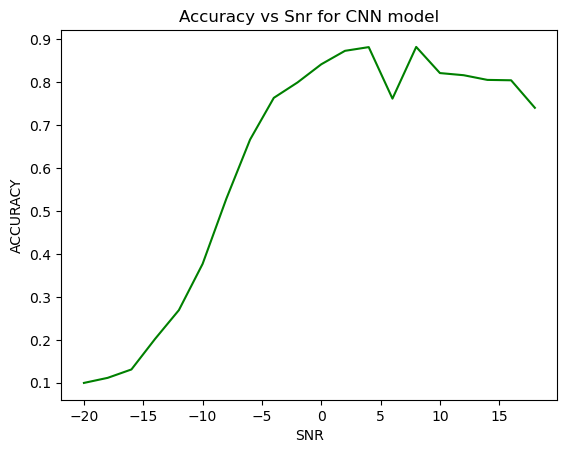

In [23]:
import matplotlib.pyplot as plt
plt.plot(snr,acc,color='green')
plt.xlabel("SNR")
plt.ylabel("ACCURACY")
plt.title("Accuracy vs Snr for CNN model")
plt.show()

In [ ]:
models_cnn.summary()

In [1]:
models_cnn.save("CNN_model.h5")

NameError: name 'models_cnn' is not defined

In [ ]:
confusion_matrices_All_cnn